In [1]:
# Librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from statsmodels.tsa.stattools import adfuller
from pylab import *
from ztrans import *

## Análisis de Series de Tiempo

### 2.1 Procedimiento

In [7]:
'''
1. La señal corresponde a datos de la tasa de cambio representativa del mercado (TRM), la cual mide la cantidad
de pesos colombianos por un dólar de los Estados Unidos. El archivo historical TRM.csv contiene 6 columnas
con la siguiente información:

Fecha
Precio
Apertura
Máximo
Mínimo
Cambio
'''

# Cargar el archivo TRM
def extract_currency(x):
  if isinstance(x, str):
    return(x.replace('%', '').replace(',', ''))
  return(x)

df = pd.read_csv('/content/historical_TRM.csv', delimiter=',')
print(df)


# Extracción de datos
precio  =  np.array(df['Precio'].apply(extract_currency).astype('float'))[::-1]
fecha =  np.array(df['Fecha'])[::-1]
cambio =  np.array(df['Cambio'].apply(extract_currency).astype('float'))[::-1]


          Fecha    Precio  Apertura    Maximo    Minimo  Cambio
0    01/01/2023  4,859.00  4,848.00  5,008.88  4,818.11   0.25%
1    12/25/2022  4,847.00  4,729.00  4,851.90  4,727.21   2.51%
2    12/18/2022  4,728.33  4,790.26  4,790.63  4,727.79  -1.19%
3    12/11/2022  4,785.51  4,809.85  4,861.00  4,757.65  -0.43%
4    12/04/2022  4,806.00  4,771.54  4,843.88  4,765.20   0.78%
..          ...       ...       ...       ...       ...     ...
517  02/03/2013  1,786.34  1,777.11  1,799.46  1,777.06   0.57%
518  01/27/2013  1,776.20  1,778.90  1,782.05  1,764.65  -0.16%
519  01/20/2013  1,779.12  1,769.28  1,782.97  1,768.17   0.54%
520  01/13/2013  1,769.50  1,763.00  1,778.70  1,756.11   0.35%
521  01/06/2013  1,763.40  1,771.73  1,774.00  1,758.50  -0.45%

[522 rows x 6 columns]


In [8]:
'''
2. Utilice la columna Fecha y calcule el periodo de muestreo para esta serie de tiempo. Expréselo en días, semanas
y años.
'''

df['Fecha'] = pd.to_datetime(df['Fecha']) # Para poder realizar operaciones

data = df.sort_values(by ='Fecha', ascending=True) # Ordeno ascendentemente

dif_row = data['Fecha'].diff().dropna() # Calculo la diferencia entre cada elemento de la fila

prom_fecha = dif_row.mean() # Estimo el Ts de los datos

# Periodo de muestreo Ts
print("Periodo de muestreo:")
print(prom_fecha.days, 'días')
print(prom_fecha.days/7, 'semanas')
print(prom_fecha.days/365, 'años')

Periodo de muestreo:
7 días
1.0 semanas
0.019178082191780823 años


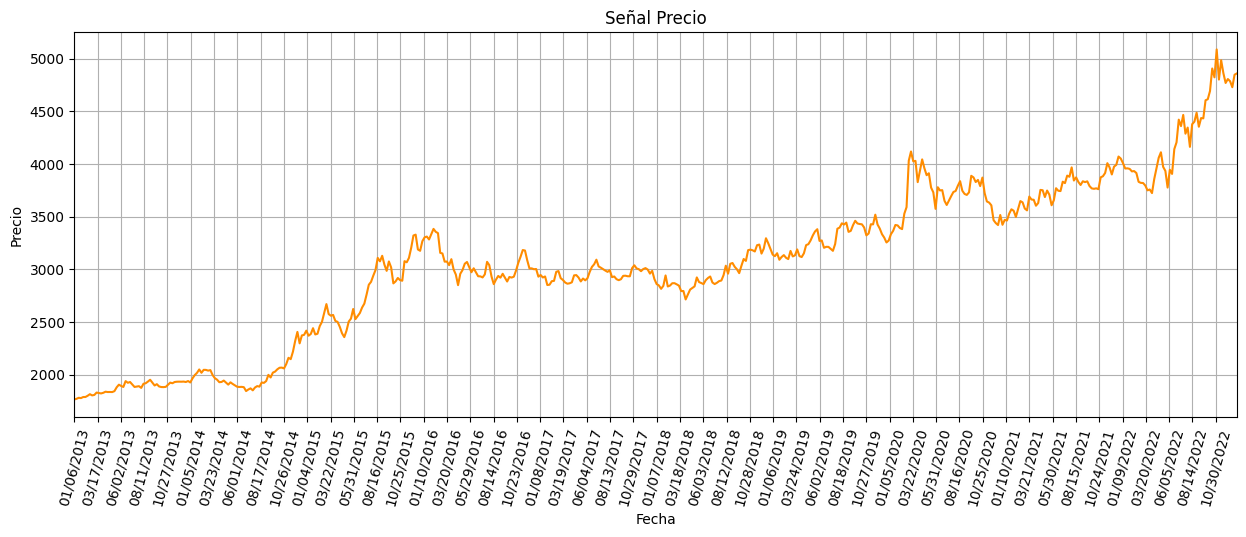

In [9]:
'''
3. Grafique la señal Precio en función del tiempo y presente un análisis sobre la misma.
'''

plt.figure(figsize=(15,5))
plt.plot(fecha, precio, '#FF8C00')
plt.tick_params(axis='x' , rotation=75) # Para rotación de etiquetas en eje x
plt.xticks(list(np.arange(0,len(fecha),len(fecha)/50))) # Genero 50 ticks
plt.xlim(fecha[0], fecha[-1])
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title("Señal Precio")
plt.grid()
plt.show()

A través de la gráfica se ve un alza de la moneda colombiana al cambio con el dolar, esto se traduce en una devaluación de la misma.

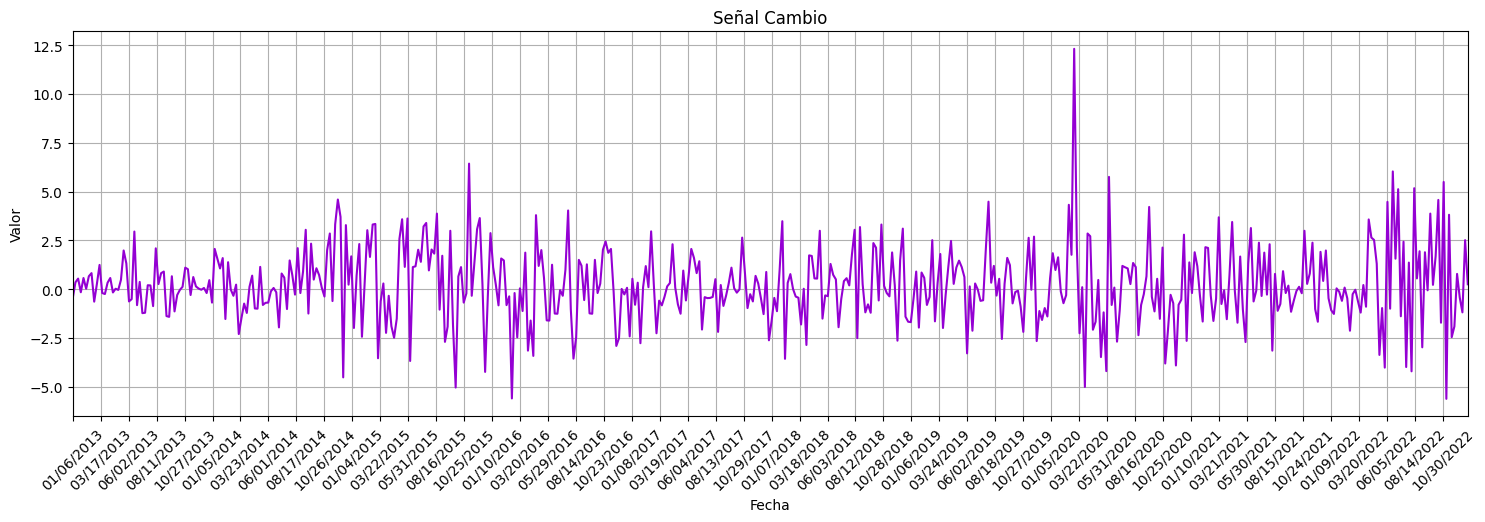

In [11]:
'''
4. Grafique la señal Cambio en función del tiempo y presente un análisis sobre la misma.
'''

plt.figure(figsize=(18,5))
plt.plot( fecha, cambio, '#9400D3')
plt.tick_params(axis='x' , rotation=45)
plt.xticks(list(np.arange(0,len(fecha),len(fecha)/50)))
plt.xlim(fecha[0], fecha[-1])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title("Señal Cambio")
plt.grid()
plt.show()

Los picos o cambios abruptos en la gráfica indican la inestabilidad de la moneda en esos periodos, ya sea un disparo de la divisa o un decaimiento.
Se aprecia también que en 2020 se da el mayor pico que también corresponde con una gran devaluación mostrada en la gráfica anterior de Precio.

Coeficiente de autocorrelación para la Señal Precio 1.0
Coeficiente de correlación para la Señal Precio y la Señal Cambio 0.8923021588238108


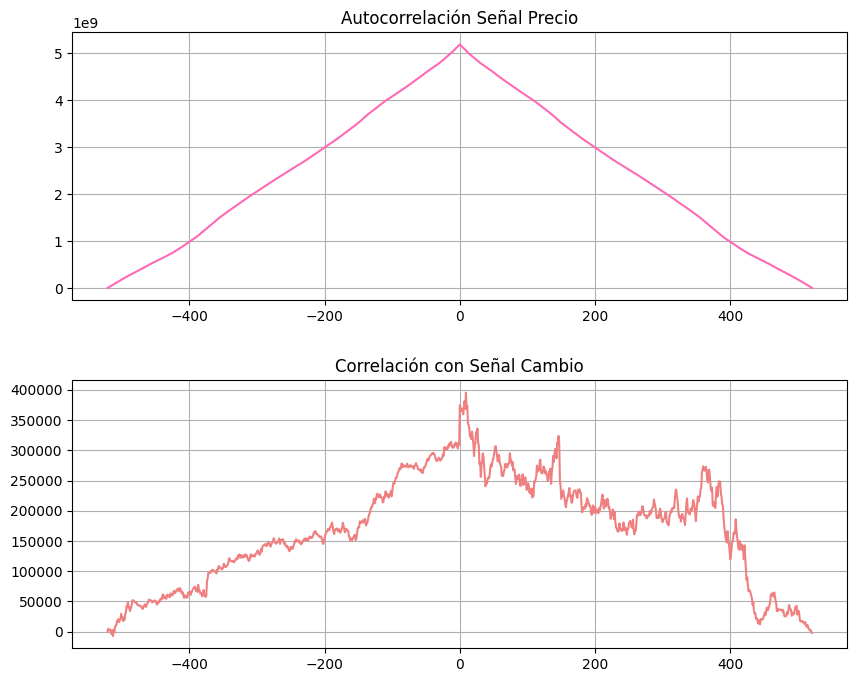

In [12]:
'''
5. Calcule la autocorrelación de la señal Precio y la correlacion con la señal Cambio. ¿Qué puede concluir del
resultado?
'''

Rpp = np.correlate(precio, precio, mode='full')
Rxy = np.correlate(precio, cambio, mode='full')
tau = np.arange(-len(precio)+1,len(precio),1) # Vector de retraso

# Gráficas
fig, axs = plt.subplots(2, figsize=(10,8))
axs[0].plot(tau, Rpp, '#FF69B4')
axs[0].set_title('Autocorrelación Señal Precio')
axs[0].grid()
axs[1].plot(tau,Rxy, '#F08080')
axs[1].set_title('Correlación con Señal Cambio')
axs[1].grid()
fig.subplots_adjust(hspace = 0.3)


#Coeficientes de correlación
print('Coeficiente de autocorrelación para la Señal Precio', np.corrcoef(Rpp,Rpp)[0,1])
print('Coeficiente de correlación para la Señal Precio y la Señal Cambio', np.corrcoef(Rpp,Rxy)[0,1])

Hay una relación lineal entre las señales Precio y Cambio, pues su correlación es cercana a 1




In [13]:
'''
6. Investigue para qué se utiliza el test Dickey-Fuller, aplíquelo a sus dos señales y concluya. Esto también le
servirá de referente para elaborar su conclusión en los próximos numerales.


Es una prueba de raíz unitaria utilizada para determinar si una serie temporal es estacionaria o no.
La estacionariedad implica a las propiedades estadísticas de la serie, como la media y la varianza, y determina si
constantes a lo largo del tiempo.
'''

# Para la Señal Precio
adf1 = adfuller(precio)

# Para la Señal Cambio
adf2 = adfuller(cambio)

# Resultados
print("Resultado para el precio:")
print("Estadística de prueba:", adf1[0]) # Estadística de Prueba
print("Valor p:", adf1[1]) # Valor P (determina si la serie es estacionaria o no)
print("Valores críticos:", adf1[4]) # Valores Críticos

print("Resultado para el cambio:")
print("Estadística de prueba:", adf2[0])
print("Valor p:", adf2[1])
print("Valores críticos:", adf2[4])

Resultado para el precio:
Estadística de prueba: 0.3031204192267226
Valor p: 0.9774871972556075
Valores críticos: {'1%': -3.4433139398425348, '5%': -2.867257567756961, '10%': -2.5698152474041915}
Resultado para el cambio:
Estadística de prueba: -13.470518522141989
Valor p: 3.389582867374799e-25
Valores críticos: {'1%': -3.4430126933746767, '5%': -2.8671249839002764, '10%': -2.569744590233924}


p < 0.05 → se rechaza la hipótesis nula de que la serie tiene una raíz unitaria y se concluye que la serie es estacionaria.

p > 0.05 → no se rechaza la hipótesis nula y se concluye que la serie es no estacionaria.

Para la Señal Precio se tiene una serie no estacionaria.
Para la Señal Cambio se tiene una serie estacionaria

## Filtro de Media Móvil

### 3.1 Procedimiento

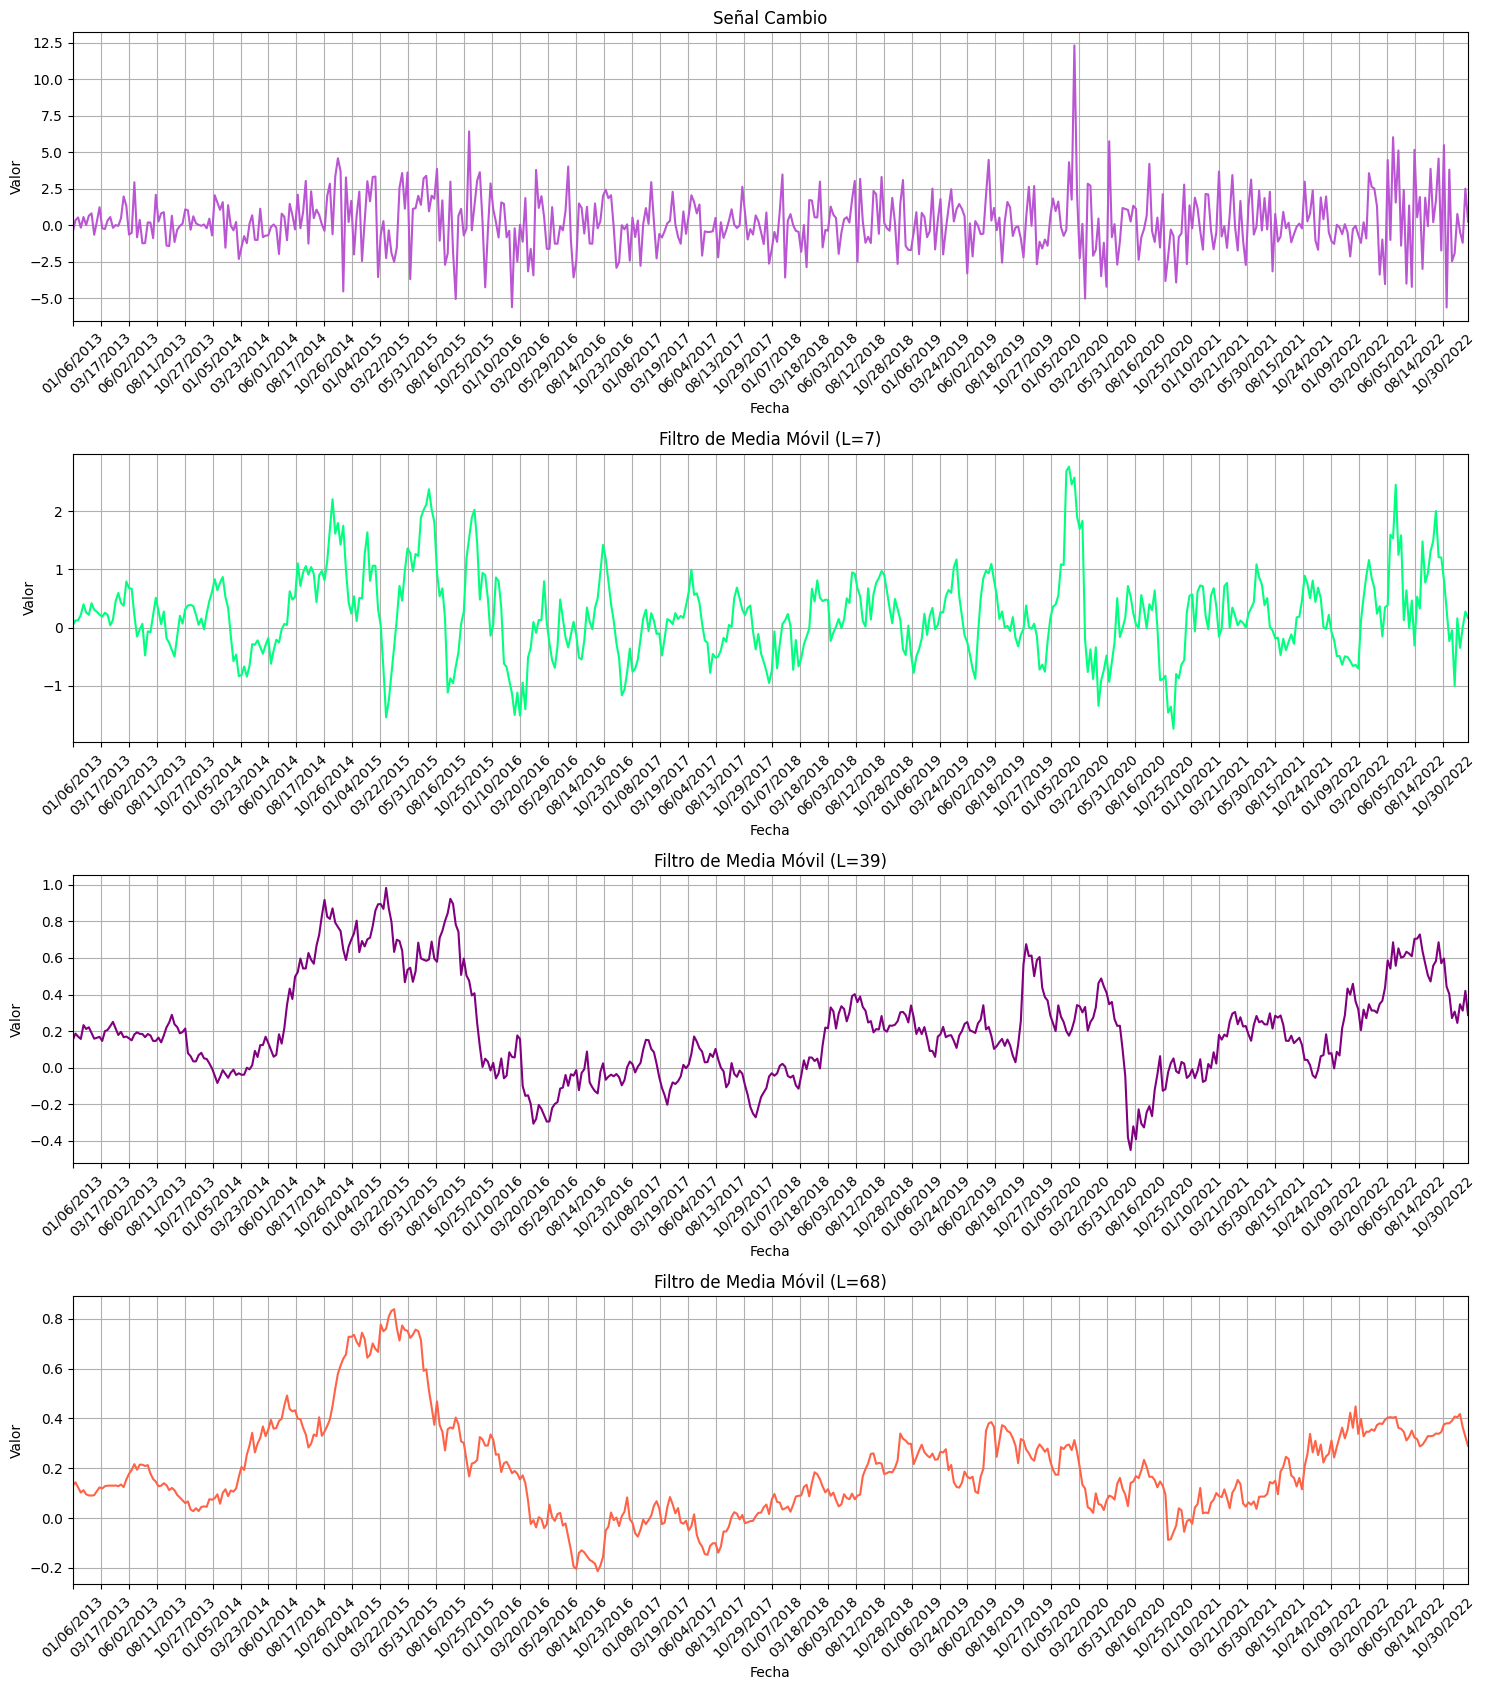

In [14]:
'''
1. Diseñe un filtro de media móvil con 3 diferentes valores de L en el rango de 5 a 70, calcule la respuesta de la
señal Cambio (obtenida en el punto 2.1.6) ante dicho filtro y grafique la señal resultante usando subplots (se
puede utilizar el vector de tiempos generado anteriormente). ¿Con cuál considera que se visualiza y se podría
analizar mejor la información?
'''
colors = ['#00FF7F', '#800080', '#FF6347']
L = [7,39,68] # Definición de ventana

# Señal Original
plt.figure(figsize=(15,17))
plt.subplot(4,1, 1 )
plt.plot(fecha, cambio, '#BA55D3')
plt.title('Señal Cambio')
plt.xlim(fecha[0], fecha[-1])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.tick_params(axis='x' , rotation=45)
plt.xticks(list(np.arange(0,len(fecha),len(fecha)/50)))
plt.grid()

# Gráfica para los filtros
for i in range(0,3):
    l =  L[i]
    coefs  = np.ones(l)/float(l) # Cantidad de puntos usados en el filtro
    con =  np.convolve(cambio , coefs ,  mode ='same') # Convolución
    plt.subplot(4,1, i+2)
    plt.plot(fecha, con, color=colors[i])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title(f'Filtro de Media Móvil (L={l})')
    plt.xlim(fecha[0], fecha[-1])
    plt.tick_params(axis='x' , rotation=45)
    plt.xticks(list(np.arange(0,len(fecha),len(fecha)/50)))
    plt.grid()

plt.tight_layout()
plt.show()

La información original se distorsiona a medida que el valor de L se hace mayor, ya que para L = 39 y L = 68 se suavizan curvas que en la señal original son imprescindibles para señalar cambios en la divisa.

Se confirma que el filtro de media móvil sí suaviza la señal pero en estos casos no es conveniente aplicarlo, ya que cada pico brinda información importante.

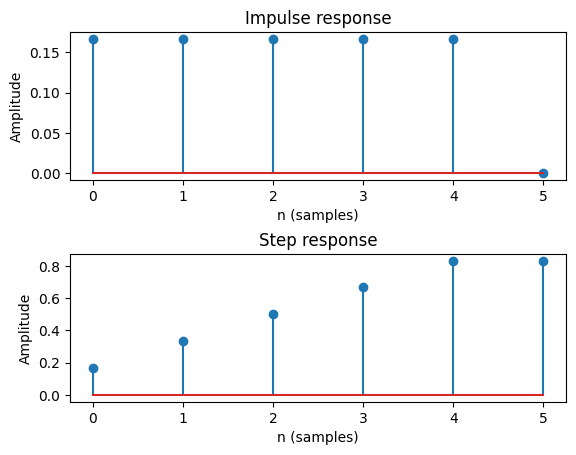

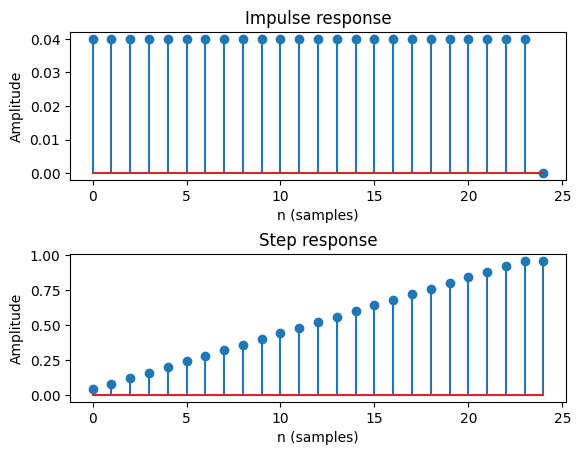

In [ ]:
'''
3. Utilice la función impz para graficar y analizar la respuesta al impulso y al escalón del filtro de media móvil.
¿Qué me indica la respuesta al impulso? Compare los resultados con L = 6 y L = 25.
'''

puntos = [6,25]
for L in puntos:
    num=np.zeros(L)
    num[0]=1.0/L
    num[-1]=-1.0/L
    den=np.zeros(L)
    den[0]=1
    den[1]=-1
    impz(num,den) # Grafica y analiza la respuesta al impulso de un sistema discreto

Para la señal escalón, el filtro con un L bajo la suavizó pero es más notable cuando L es mayor, hay una mayor cantidad de puntos y no hay curvas bruscas, características del escalón.

Para el impulso, se nota también una mayor cantidad de muestras a medida que L es mayor, así como una amplitud de muestras indirectamente proporcional a L.


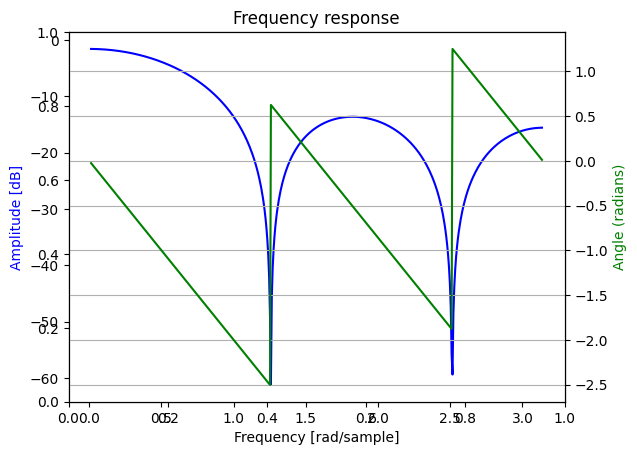

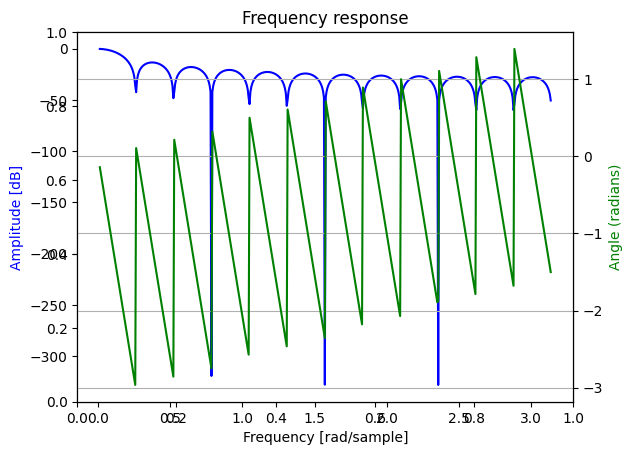

In [ ]:
'''
4. Utilice la función mfreqz para graficar y analizar la respuesta en frecuencia del filtro de media móvil.
¿Qué tipo de filtro es? ¿Cómo es su respuesta en fase?  Compare los resultados con L = 6 y L = 25.
'''

puntos = [6,25]
for L in puntos:
    num=np.zeros(L)
    num[0]=1.0/L
    num[-1]=-1.0/L
    den=np.zeros(L)
    den[0]=1
    den[1]=-1
    mfreqz(num,den) # Grafica y analiza la respuesta en frecuencia de un sistema discreto

El filtro de media móvil es un filtro pasa bajas que atenúa las frecuencias más altas y deja pasar las frecuencias más bajas.
Lo anterior se evidencia en la respuesta en frecuencia, donde la ganancia del filtro disminuye cuando la frecuencia aumenta.


## Filtro de Primera Diferencia

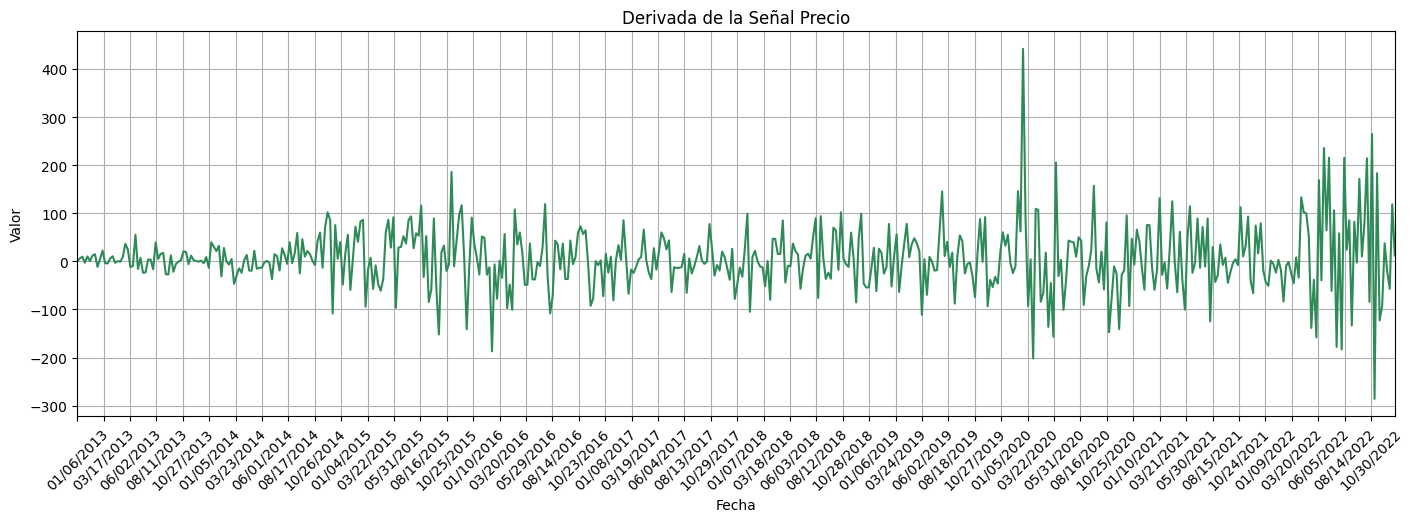

In [15]:
'''
1. Mediante la función de convolución utilizada anteriormente, calcule la derivada de la señal con el filtro de
primera diferencia, grafique y analice brevemente la señal resultante. ¿Qué me indica esta señal?
'''

difcoefs=[1, -1]
conv =  np.convolve(precio , difcoefs ,  mode ='same') # Se hace la convolución

# Gráfica
plt.figure(figsize=(17,5))
conv[0]= 0 # No hay datos anteriores
plt.plot(fecha, conv, '#2E8B57')
plt.title('Derivada de la Señal Precio')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.tick_params(axis='x' , rotation=45)
plt.xticks(list(np.arange(0,len(fecha),len(fecha)/50)))
plt.xlim(fecha[0], fecha[-1])
plt.grid()
plt.show()


La derivada indica el cambio de la señal en cada punto, por lo que un pico positivo indica un incremento, mientras que un pico negativo indica decrementos.
En general, la señal es semejante a la original, ya que ambas indican cambios que se reflejan en los mismos periodos.

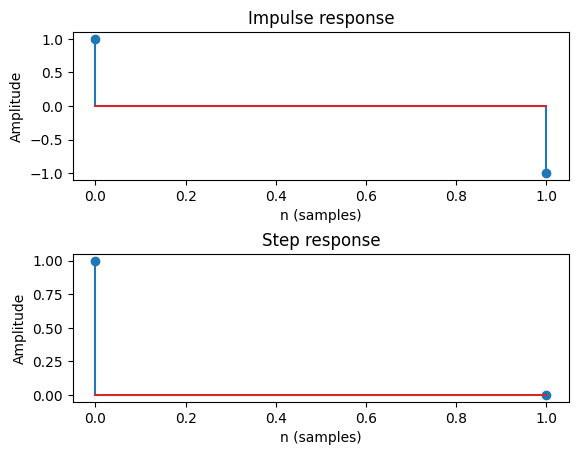

In [16]:
'''
2. Utilice la función impz para graficar y analizar la respuesta al impulso y al escalón del filtro de primera
diferencia. ¿Qué me indica la respuesta al impulso?
'''

num=[1,-1]
den=[1,0]
impz(num,den)

La respuesta al impulso para este tipo de filtros retorna un impulso en n = 0

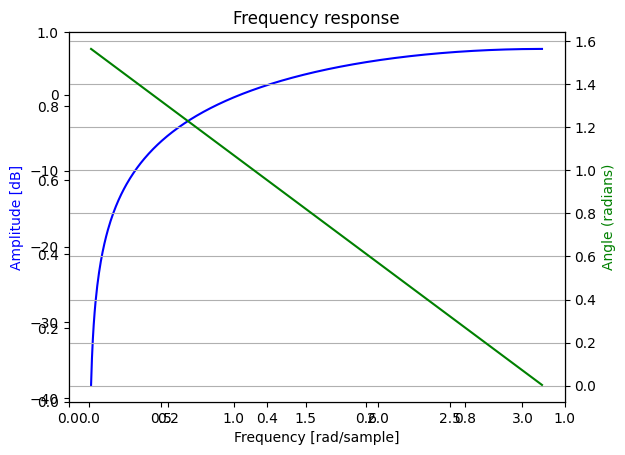

In [17]:
'''
3. Utilice la función mfreqz para graficar y analizar la respuesta en frecuencia del filtro de primera diferencia.
¿Qué tipo de filtro es? ¿Cómo es la respuesta de fase?
'''

num = [1, -1]
den = [1, 0]
mfreqz(num,den)

Al tratarse de la diferencia, se obtiene un filtro pasa altas, que atenúa las bajas frecuencias para dejar pasar las altas. Este filtro también tiene en fase una respuesta lineal.


## Conclusiones

Para los filtros de media móvil, debe tenerse presente que cuando hay falta de puntos en los extremos, se podría perder calidad en el resultado.

Algunos filtros que suavizan las señales no son convenientes para aplicaciones específicas, en donde los picos que son suavizados indican cambios en una variable y por ende, luego del filtrado se podrían perder estos detalles.

Los filtros de primera diferencia son usados para remarcar cambios bruscos en una señal.
